# LSH Investigation

Taking inspiration from previous assignments, LSH was used to similarity bucket the websites based on their texts. Each site was treated as a single ‘article’ by compressing all statuses into a single one-line feature, and then tokenizing that one-line feature for LSH analysis and filtering through Jaccard similarity.

Three key parameters were tweaked in this process. Ngram length (N), x number of top ngrams (MC), and Jaccard similarity threshold (T). These were tweaked to see the relationship between phrases and words in the similarity relationship between the sites. The goal here is to analyze and understand the relationship between articles through their similarity under different parameters, and through this investigate the nature of the partisan sites further, before we commence further unsupervised machine learning paradigms to pro- duce predictive results. The aim therefore is to deconstruct whether the labeling was indeed done correctly, and if so, what further dimen- sions might the sites fall under past the binary left/right dichotomy they are corralled into.

## How CSV was prepared

Commented out code showing how input file was created based off of earlier pre-processing by others. merged_data was received already collated between sites and facebook statuses, and this was the further work done to prepare it for LSH analysis using 'oneline articles'.

In [ ]:
'''

from collections import defaultdict

newdf = merged_data
unique_fb_ids = newdf.fb_id.unique()
newdf2 = newdf.loc[newdf['fb_id'] == "161453087348302"]

maindf = pd.DataFrame(columns = ["fb_id", "website", "political_category", "macedonian", "fan_count"])
newdict = newdf.to_dict()

newdict2 = {}

for count, x in enumerate(unique_fb_ids):

    tempdf =  newdf.loc[newdf['fb_id'] ==  x]
    tempdict = tempdf.to_dict()

    temptempdict = tempdict["status_id"]
    tempList = list(temptempdict.keys())
    first_value = tempList[0]

    
    fb_id =  x
    website =  tempdict["website"][first_value]
    political_category =  tempdict["political_category"][first_value]
    macedonian =  tempdict["macedonian"][first_value]
    fan_count =  tempdict["fan_count"][first_value]

    newdict3 = {'fb_id' : fb_id, 'website' : website, 'political_category' : political_category, 'macedonian' : macedonian, 'fan_count' : fan_count, 'status': ""}
    
    statuses = tempdict["status_message"]

    for count, x in enumerate(statuses):
        if type(statuses[x]) == str:
            newdict3['status'] += statuses[x]
        else:
            newdict3['status'] += ""

    newdict2[count] = newdict3




testdf = pd.DataFrame.from_dict(newdict2).T
testdf



testdf.to_csv("/Users/kathirtahasin/Desktop/Stavanger/DAT550/project/all_status_matrix.csv")


'''


## Import packages

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
from collections import Counter
from scipy.sparse import csr_matrix
import random
import matplotlib.pyplot as plt


from nltk import ngrams
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')

cachedStopWords = set(stopwords.words("english"))

import copy
import ssl

ssl._create_default_https_context = ssl._create_unverified_context


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kathirtahasin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kathirtahasin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


##  Import the premade file and convert into a Dataframe.

In [4]:
# Import articles

df = pd.read_csv ('../data/oneline_status_matrix.csv')

In [151]:
df.rename(columns={'fb_id': 'article_id', 'political_category': 'Title', 'status': 'Content'}, inplace=True) #rename to reuse old code


## Clean df by finding punction and linebreaks and replacing with empty string. Uppercase to Lowercase.

In [152]:
# Replace punction with empty string

punctuation_finder = re.compile(r'[^\w\s]+') #to find punctiuation expression

df['Content']= df['Content'].astype(str).str.replace('\\r\\n', '')
print(type(df['Content'][0]))

df['Content'] = [punctuation_finder.sub('', x) for x in df['Content'].tolist()] #replace punction with empty string


# Replace linebreak with empty string

df = df.replace(r'\n',' ', regex=True) 

# Change case to all lower

df['Content'] = df['Content'].str.lower()


/var/folders/t7/jxcd3lhd16q_l5thdj6ncv880000gn/T/ipykernel_49916/2833649245.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Content']= df['Content'].astype(str).str.replace('\\r\\n', '')


<class 'str'>


In [153]:
df.head(10)

,Unnamed: 0,article_id,website,Title,macedonian,fan_count,Content
0,3969,161453087348302,committeetodefendthepresident.com/,right,0,795896,hello my name is pippa becca i set out to prov...
1,145825,532734866892797,NaN,right,0,1062633,sheppard smith is one of those people that see...
2,7991,475549362567960,https://conservativereview.com,right,0,1542369,it had everything to do with hurting and embar...
3,10479,186457858051439,latinorebels.com,left,0,102935,to beat ted cruz beto orourke plans to throw o...
4,2405,329417987110870,conservativeintel.com,right,0,300511,lets work to kill obamacare by taking away its...
5,5708,1435071773455316,dailywire.com/,right,0,1575837,do youwithin our borderswhat do you thinkheres...
6,196,372220329789295,interestingdailynews.com/,right,1,4346,please pass on this information to your friend...
7,852,121664761245469,politicsdoneright.com,left,0,18596,i just logged into facebook and was hit with a...
8,322,1414486152197718,craigjames.com,right,0,100598,prestonwood baptist church is hosting a group ...
9,22427,177486166274,beingliberal.org,left,0,1674268,s clean air clean water continues to be an imp...


## Trigrams per Article

In [154]:
def createNgrams(articles):

    id = 0
    ngramm_array = []

    for x in articles["Content"]: #for each objects content property
        #print(x)

        tokens = word_tokenize(x)
        filtered_data = ' '.join([y for y in tokens if not y in cachedStopWords]) #cachedStopWords change?
        grams = ngrams(filtered_data.split(), 3)
        processed_ngrams = []

        for n in grams:
            token = n[0] + " " + n[1] + " " + n[2]
            processed_ngrams.append(token)
        id += 1
        ngramm_array.append(processed_ngrams)
    
    articles['Trigrams'] = ngramm_array
    
    return articles

Display trigrams for each article

In [155]:
df_ngram = createNgrams(df)
df_ngram.head()

,Unnamed: 0,article_id,website,Title,macedonian,fan_count,Content,Trigrams
0,3969,161453087348302,committeetodefendthepresident.com/,right,0,795896,hello my name is pippa becca i set out to prov...,"[hello name pippa, name pippa becca, pippa bec..."
1,145825,532734866892797,NaN,right,0,1062633,sheppard smith is one of those people that see...,"[sheppard smith one, smith one people, one peo..."
2,7991,475549362567960,https://conservativereview.com,right,0,1542369,it had everything to do with hurting and embar...,"[everything hurting embarrassing, hurting emba..."
3,10479,186457858051439,latinorebels.com,left,0,102935,to beat ted cruz beto orourke plans to throw o...,"[beat ted cruz, ted cruz beto, cruz beto orour..."
4,2405,329417987110870,conservativeintel.com,right,0,300511,lets work to kill obamacare by taking away its...,"[lets work kill, work kill obamacare, kill oba..."


## Most Common Trigrams

Three element ngrams was found to be the best. Looped through the articles to find trigrams, then ngram checked not to be a cached stopword, and most_common() used to find top 10000 ngrams.

In [156]:
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [157]:
def getFrequentNgrams(articles):
    data = (" ").join(articles["Content"])
    data_tokens = word_tokenize(data)
    filtered_data = ' '.join([y for y in data_tokens if not y in cachedStopWords]) #cachedStopWords change?
    
    n = 3
    created_grams = ngrams(filtered_data.split(), n)
    created_grams_count = Counter(created_grams)
    created_grams_count = created_grams_count.most_common(1000)
    
    created_ngrams = []
    for n, m in created_grams_count:
        token = n[0] + " " + n[1] + " " + n[2]
        created_ngrams.append(token)
    return created_ngrams

Display most common trigrams array and its shape.

In [158]:
freq_gram = getFrequentNgrams(df)
print (np.shape(freq_gram))
freq_gram

(1000,)


['donald j trump',
 'get conservative news',
 'free iphone ipad',
 'conservative news 63redcom',
 'news 63redcom free',
 '63redcom free iphone',
 'iphone ipad app',
 'ipad app httpsappstorei6hk5mf',
 'app httpsappstorei6hk5mf trump',
 'dare join fight',
 'patriots dare join',
 'join fight save',
 'fight save america',
 'save america click',
 'america click httpbb4spcom',
 'httpsappstorei6hk5mf trump hillary2016',
 'trump hillary2016 maga',
 'joemygodlatest joemygodlatest joemygodlatest',
 'black lives matter',
 'httpsappstorei6hk5mf trump tcot',
 'trump tcot maga',
 'water n woods',
 'bb4sp patriots dare',
 'donald j trumps',
 'new york times',
 'get 10000 likes',
 'click httpbb4spcom bb4sp',
 'never see video',
 'httpbb4spcom bb4sp patriots',
 'news likes http63redcom',
 'likes http63redcom free',
 'http63redcom free iphoneipad',
 'free iphoneipad app',
 'iphoneipad app thanks',
 'app thanks using',
 'thanks using 63red',
 'using 63red conservative',
 'get 5000 likes',
 '63redget news

## Binary Matrix
Most common 10k trigrams set against trigras for each article to create binary matrix.

In [159]:
#Preparing the input files
docs = df_ngram["Trigrams"]
docs = docs.apply(lambda row: np.intersect1d(row, freq_gram))

In [160]:
def getBinaryMatrix(docs):
    
    indentpoint = [0]
    indexes = []
    data_array = []
    vocabulary_dict = {}

    for line in docs:

        for x in line:

            index = vocabulary_dict.setdefault(x, len(vocabulary_dict))
            indexes.append(index)
            data_array.append(1)

        indentpoint.append(len(indexes))
        
    binary_matrix = np.transpose(csr_matrix((data_array, indexes, indentpoint), dtype=int).toarray())
    
    return binary_matrix

Display binary matrix and its shape. Set variable name here.

In [161]:
binary_matrix = getBinaryMatrix(docs)
print(np.shape(binary_matrix))
binary_matrix

(1000, 440)


array([[1, 1, 0, ..., 1, 1, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Minhash values

In [162]:
def getHashFunctionValues(numrows, numhashfunctions):

    hash_mat = []

    for x in range(numhashfunctions):

        row = []
        randomInt = int(random.getrandbits(32))

        for y in range(numrows):

            row.append((hash(y)^randomInt))

        hash_mat.append(row)
        
    return np.array(hash_mat)

Set minhash matrix name here.

In [163]:
hash_val_matrix = getHashFunctionValues(binary_matrix.shape[0], 200)

## Signature Matrix
Will use hash value matrix and binary matrix set earlier

In [164]:
def getMinHashSignatureMatrix(binary_matrix, hash_val_matrix):

    sign_matrix = np.full((hash_val_matrix.shape[0], binary_matrix.shape[1]), np.inf)

    for i in range(binary_matrix.shape[0]):

        for j in np.where(binary_matrix[i] == 1)[0]:

            for h in range(hash_val_matrix.shape[0]):

                if sign_matrix[h][j] == np.inf or sign_matrix[h][j] > hash_val_matrix[h][i]:

                    sign_matrix[h][j] = hash_val_matrix[h][i]
                    
    return sign_matrix

Set minhash signature matrix name here.

In [165]:
signature_matrix = getMinHashSignatureMatrix(binary_matrix, hash_val_matrix)

## Locality Sensitive Hash

Finally the more efficient signature matrix can create the buckets of candidate pairs.

In [166]:
def getLSH(signature_matrix, num_bands, num_buckets):
    
    local_sHash = {}

    ran = int(signature_matrix.shape[0]/num_bands)

    for x in range(num_bands):

        rInt = int(random.getrandbits(32))

        for y in range(signature_matrix.shape[1]):

            hashValue = hash(tuple(signature_matrix[x*ran:(x+1)*ran,y]))^rInt

            if hashValue not in local_sHash:

                local_sHash[hashValue] = set()
                
            local_sHash[hashValue].add(y)
    
    return local_sHash
    

Set lsh var name here.

In [167]:
locality_sensitive_hash = getLSH(signature_matrix, 20, 1e6)

## Visual threshold inspection for paramter tuning

In [168]:
def plotProbability(s, b, r):

    fig = plt.figure()
    ax = plt.axes()
    ax.set_title(f"LIMIT: {np.round(s, 1)}")

    plt.axvline(x=s)

    for i in range(len(b)):
        x = np.sort(np.random.uniform(0,1,1000), axis=0)
        y = 1 - (1-x**r[i])**b[i]
        ax.plot(x,y, label =f"b={b[i]}, r={r[i]}")
        
    ax.legend()
   

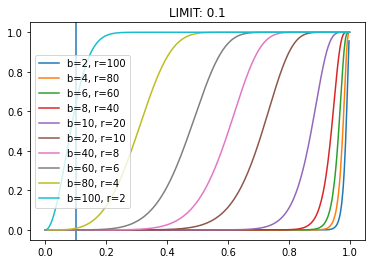

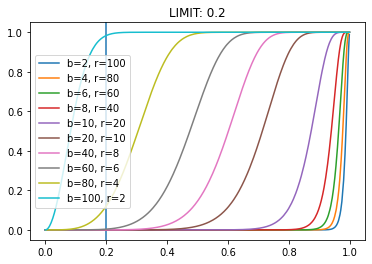

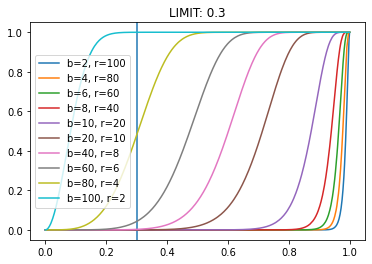

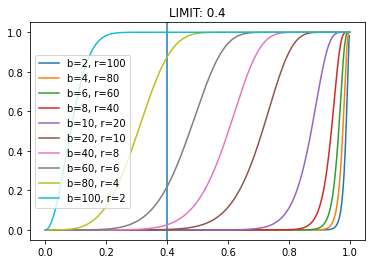

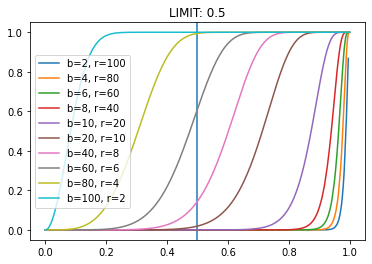

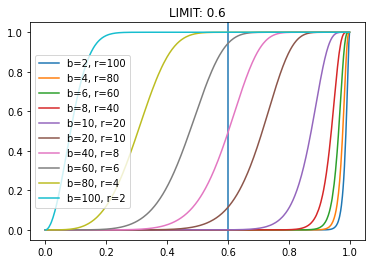

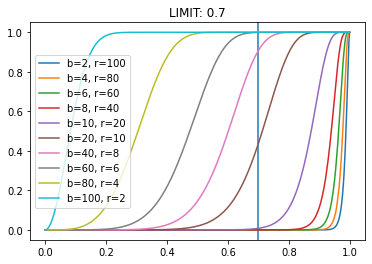

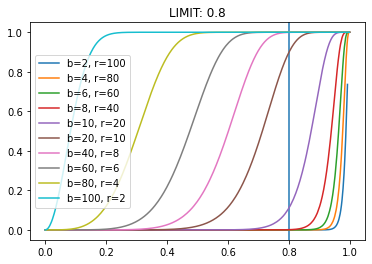

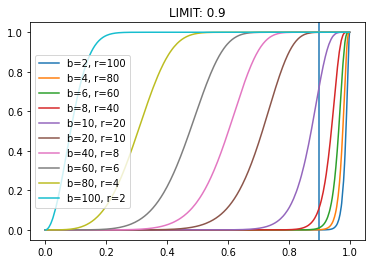

In [169]:
nums = [2, 4, 6, 8, 10, 20, 40, 60, 80, 100]


for s in np.linspace(0.1, 0.9, 9):
    plotProbability(s, nums, list(reversed(nums)))

Over here we use these values to understand what behaviour different thresholds would indicate. 0.4 was chosen as a basic baseline for similarity to further instigate investigation.

## Jaccard Similarity Scoring between Classes

In [170]:
def getJaccardSimilarityScore(C1, C2):
    u = np.sum(np.bitwise_or(C1, C2))
    A = np.sum(np.bitwise_and(C1, C2))
    if u == 0: return 0
    else: return A/u

## Hash table to dictionary

In [171]:
nearest_neighbors = {}

for bucket, article_numbers in locality_sensitive_hash.items():
    
    for article in article_numbers:

        if article not in nearest_neighbors:

            nearest_neighbors[article] = set()

        nearest_neighbors[article].update([i for i in article_numbers if i != article])
        

Keep only the neighbours with Jaccard similarity above threshold. #NB! TAKES VERY LONG!

In [181]:
threshold = 0.4

data = pd.DataFrame()
n_copy = copy.deepcopy(nearest_neighbors)
submission_id = []
submission_nid = []

for articleId, neighborId in n_copy.items():

    for nid in neighborId:

        Jscore = getJaccardSimilarityScore(binary_matrix[:, articleId], binary_matrix[:, nid])

        if Jscore < threshold:
            nearest_neighbors[articleId].remove(nid)
        else:
            submission_id.append(articleId)
            submission_nid.append(nid)


data['article_id'] = submission_id
data['neighbor_id'] = submission_nid
data.sort_values(by=['article_id', 'neighbor_id'], inplace=True)

And the result is:

In [182]:
data.head(1000)

,article_id,neighbor_id
0,17,89
1,39,96
2,67,98
5,67,223
3,67,355
4,67,395
6,71,419
7,89,17
9,96,39
8,96,298


In [183]:
data.shape

(48, 2)

In [184]:
mismatch_number = 0
for index, row in data.iterrows():
    article_id = row['article_id']
    neighbor_id = row['neighbor_id']
    print(df['Title'][article_id],df['Title'][neighbor_id], df['website'][article_id],df['website'][neighbor_id] )
    if df['Title'][article_id] != df['Title'][neighbor_id]:
        mismatch_number = mismatch_number + 1
mismatch_ratio = str(round(mismatch_number/len(data)*100))
print(mismatch_ratio + '% percent mismatch')

right right freepatriotpost.com redrocktribune.com
right right endingthefed.com/ worldnewspolitics.com
right right godfatherpolitics.com/ visiontoamerica.org
right right godfatherpolitics.com/ conservativebyte.com
right right godfatherpolitics.com/ conservativevideos.com
right right godfatherpolitics.com/ freedomforce.com/
right left washingtonexaminer.com msnbc.com
right right redrocktribune.com freepatriotpost.com
right right worldnewspolitics.com endingthefed.com/
right right worldnewspolitics.com nan
right right visiontoamerica.org godfatherpolitics.com/
right right visiontoamerica.org freedomforce.com/
right right theblacksphere.net  allenwestrepublic.com
left left dieharddemocrat.com dieharddemocrat.com
right right eaglerising.com/ allenwestrepublic.com
right right thedeplorablearmy.com nan
right right thedeplorablearmy.com tothedeathmedia.com
right right americanjournalreview.com westernsentinel.com
right right conservativebyte.com godfatherpolitics.com/
right right conservative